Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Rita González Márquez

Summer term 2024

Name: Stephan Amann, Hannah Blaurock, David Kleindiek

# Neural Data Science Project 02

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

In [ ]:
# import packages here
import utils
from visualization import Visualization as VIS
from ipywidgets import interact, fixed, widgets
from IPython.display import display, Image, clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jupyter_black
from tqdm import tqdm

jupyter_black.load()

/home/steph/miniconda3/envs/NDS/lib/python3.10/site-packages/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


## Context
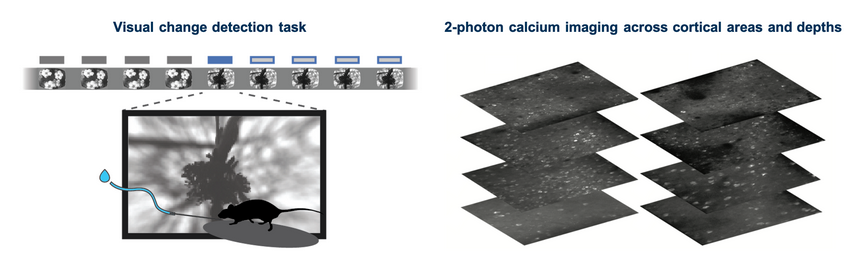

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

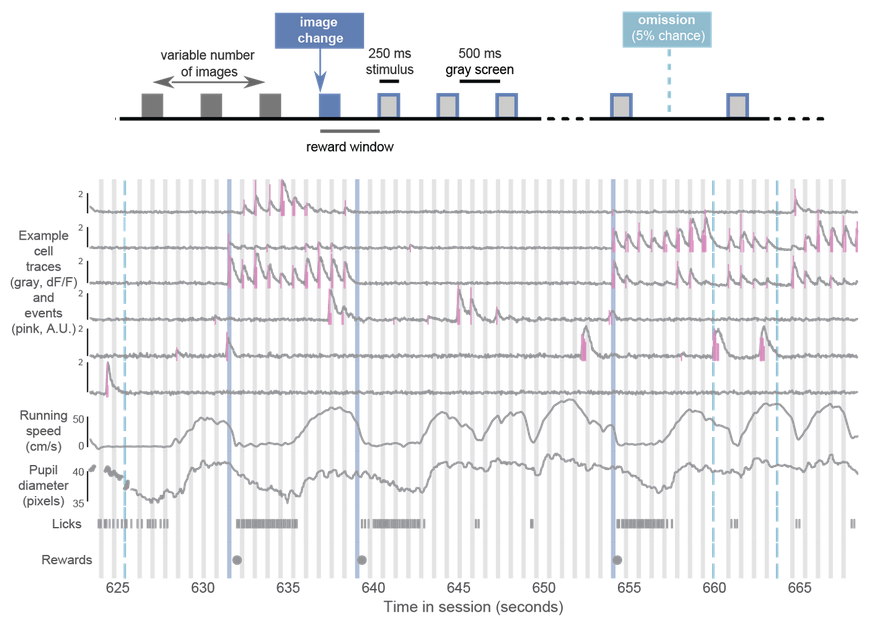

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the ROI masks for each cell
- a maximum activity projection of all ROIs
- running speed
- table of stimulus epochs

You will only work with a drifting grating stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [ ]:
# load data
def load_data(path="../data"):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_dsi.npz", allow_pickle=True)
    data = dict(data)
    print("Data keys: ", data.keys())
    array2df(
        data,
        "stim_table",
        ["temporal_frequency", "orientation", "blank_sweep", "start", "end"],
    )
    array2df(data, "stim_epoch_table", ["stimulus", "start", "end"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data()

print("Overview of the data")
print_info(data)

Data keys:  dict_keys(['t', 'dff', 'stim_table', 'roi_masks', 'max_projection', 'running_speed', 'stim_epoch_table'])
Overview of the data
[t] - <class 'numpy.ndarray'>, - (115471,)
[dff] - <class 'numpy.ndarray'>, - (106, 115471)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (628, 5)
[roi_masks] - <class 'numpy.ndarray'>, - (106, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 115471)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



# 1. Data Exploration

In [ ]:
# for visualization we use our self-written vis class to avoid clutter in this notebook.
# The data is passed to the class and assigned to variables like in this cell.
vis = VIS(data)

# assign data to variables for easier access
t = data["t"]
dff = data["dff"]
stim_table = data["stim_table"]
roi_masks = data["roi_masks"]
max_projection = data["max_projection"]
running_speed = np.nan_to_num(data["running_speed"][0], nan=0)
stim_epoch_table = data["stim_epoch_table"]

# change stim_table "start" and "end" to int for easier indexing
stim_table["start"] = stim_table["start"].astype(int)
stim_table["end"] = stim_table["end"].astype(int)

# mean time difference in t
t_diff = np.mean(np.diff(t))
print(f"Mean time difference in t: {t_diff} s with sd: {np.std(np.diff(t))} s")

fs = 1 / t_diff  # sampling frequency
dt = 1 / fs  # time step

print(f"Sampling frequency is {fs} Hz, Time Interval is {dt} s")

Mean time difference in t: 0.03325489373863341 s with sd: 4.998870724556607e-06 s
Sampling frequency is 30.070762151865303 Hz, Time Interval is 0.03325489373863341 s


In [ ]:
# activity traces of the cells and the running speed of the mouse
interact(
    vis.update_raw_activity_traces_plot,
    cellIdx=vis.cell_index_slider(37),
    sample_range=vis.time_interval_slider(),
    show_epochs=vis.checkbox(value=True, description="Show epochs stimulus is shown"),
)

interactive(children=(IntSlider(value=37, continuous_update=False, description='Cell Index:', layout=Layout(wi…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [ ]:
# overview on how ofthen a unique stimulus variant is shown to the mouse
print(stim_table.groupby(["orientation", "temporal_frequency"]).size())

# mean duration and standard deviation a gratings stimulus is shown to the mouse
shown_gratings = stim_table[stim_table["blank_sweep"] == 0.0]
mean_time = np.mean(t[shown_gratings["end"]] - t[shown_gratings["start"]])
std_time = np.std(t[shown_gratings["end"]] - t[shown_gratings["start"]])
print(
    f"Mean duration a grating stimulus is shown: {mean_time} s with std: {std_time} s"
)

# some times a blank sweep is shown to the mouse, we can check how often this happens
print("Number of blank sweeps: ", stim_table["blank_sweep"].sum())

orientation  temporal_frequency
0.0          1.0                   15
             2.0                   15
             4.0                   15
             8.0                   15
             15.0                  15
45.0         1.0                   15
             2.0                   15
             4.0                   15
             8.0                   15
             15.0                  15
90.0         1.0                   15
             2.0                   15
             4.0                   15
             8.0                   15
             15.0                  15
135.0        1.0                   15
             2.0                   15
             4.0                   14
             8.0                   15
             15.0                  15
180.0        1.0                   15
             2.0                   15
             4.0                   15
             8.0                   15
             15.0                  15
225.0        1.0  

In [ ]:
# epochs the grating stimulus is shown to the mouse
stim_epoch_table

,stimulus,start,end
0,drifting_gratings,747,18775
1,natural_movie_three,19709,37767
2,natural_movie_one,38671,47699
3,drifting_gratings,48602,66630
4,spontaneous,66780,75697
5,natural_movie_three,75698,93756
6,drifting_gratings,94659,115215


roi_masks shape:  (106, 512, 512)
roi_masks max:  1


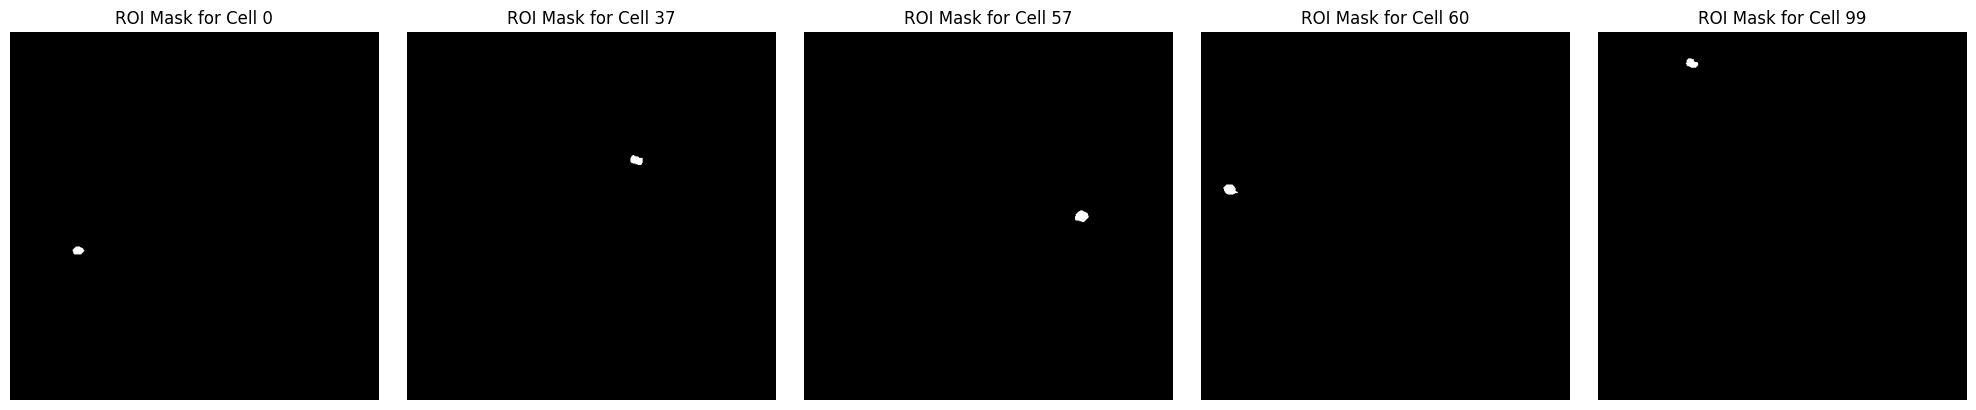

In [ ]:
# lets have a look at the ROI masks of the cells
print("roi_masks shape: ", roi_masks.shape)
print("roi_masks max: ", np.max(roi_masks))  # Values are from 0 to 1

# lets plot the masks of some cells
cells = [0, 37, 57, 60, 99]  # TODO select some nice cells
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, cell in enumerate(cells):
    axs[i].imshow(roi_masks[cell], cmap="gray")
    axs[i].set_title(f"ROI Mask for Cell {cell}")
    axs[i].axis("off")
plt.tight_layout()
plt.show()

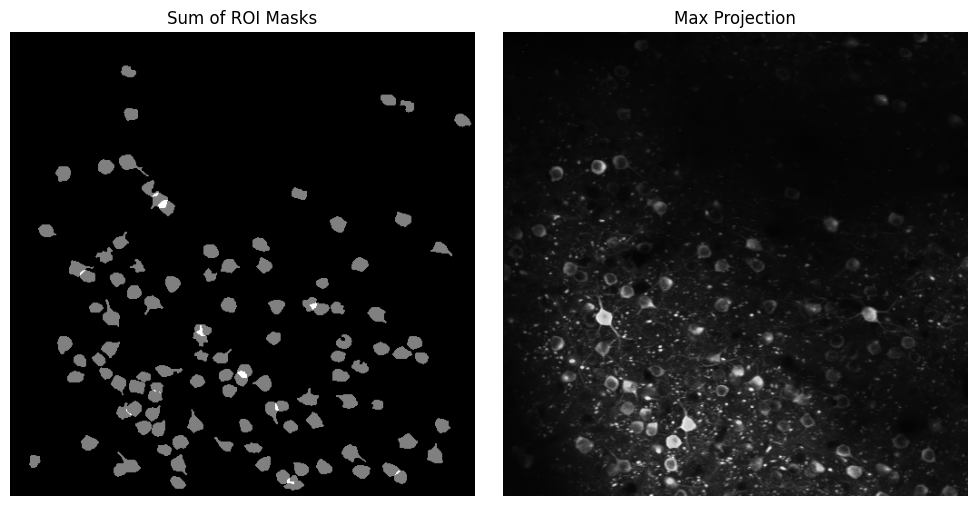

In [ ]:
# lets sum up the roi masks to get an overview of the cells and compare it to the max projection
roi_masks_sum = np.sum(roi_masks, axis=0)
roi_masks_sum = roi_masks_sum / np.max(roi_masks_sum)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(roi_masks_sum, cmap="gray")
axs[0].set_title("Sum of ROI Masks")

axs[1].imshow(max_projection, cmap="gray")
axs[1].set_title("Max Projection")

for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()

# 2. Preprocessing

TODO Text:
First we have a look at two processing methods...

### 2.1 Process Data with OOPSI

TODO Text:

In [ ]:
# butterworth filter
low = 0.3 / (fs / 2)
high = 3 / (fs / 2)

# create abs(dff)
# dff_abs[dff_abs < 0] = 0  # = np.abs(dff)
dff_butter = utils.butter_filter_signal(
    x=dff, low=low, high=high, fs=fs, order=4
)  # TODO play with parameters, ich weiß nicht mehr was die bedeuten

# as butterworth filter introduces negative values, we need to set them to zero
# dff_butter[dff_butter < 0] = 0

# wiener filter
window_wiener = 10  # TODO sollten wir hier eine windows size nehmen, die einer spike dauer entspricht?
dff_wiener = utils.wiener_filter_signal(x=dff, window=window_wiener)

# both filters applied sequentially
dff_both = utils.wiener_filter_signal(x=dff_butter, window=window_wiener)

In [ ]:
interact(
    vis.update_filter_traces_plot,
    cellIdx=vis.cell_index_slider(),
    sample_range=vis.time_interval_slider(),
    dff_butter=fixed(dff_butter),
    dff_wiener=fixed(dff_wiener),
    dff_both=fixed(dff_both),
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Cell Index:', layout=Layout(wid…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [ ]:
# we provide the processed data as a file
oopsi_from_file = True
if not oopsi_from_file:
    oopsi_spikes = utils.oopsi_inference(
        dff=dff_both, dt=dt, thresh=0.035, to_file=True
    )
else:
    oopsi_spikes = utils.load_inferred_spikes("../data/inference_oopsi.pkl")

for k in oopsi_spikes.keys():
    print(f"Key: {k}, Shape: {oopsi_spikes[k].shape}")

Key: spikes, Shape: (106, 115471)
Key: deconv, Shape: (106, 115471)
Key: binspikes, Shape: (106, 115471)


### 2.2 Process Data with OASIS

TODO Text

- Thresholding wird auch von https://doi.org/10.1371/journal.pcbi.1005423 durchgeführt, liefert ganz gut Ergebnisse

In [ ]:
# this runs for a while. You can load the results from file in the cell below instead.
# If you want to run it, set from_file=False
from_file = True
if not from_file:
    oasis_spikes = utils.oasis_inference(dff=dff, to_file=True)
else:
    oasis_spikes = utils.load_inferred_spikes("../data/inference_oasis.pkl")

for k in oasis_spikes.keys():
    print(f"Key: {k}, Shape: {oasis_spikes[k].shape}")

Key: spikes, Shape: (106, 115471)
Key: deconv, Shape: (106, 115471)
Key: binspikes, Shape: (106, 115471)


In [ ]:
interact(
    vis.update_inferred_spikes_plot,
    cellIdx=vis.cell_index_slider(),
    sample_range=vis.time_interval_slider(),
    show_oopsi=vis.checkbox(value=True, description="Show OOPSI"),
    show_oasis=vis.checkbox(value=True, description="Show OASIS"),
    oopsi_spikes=fixed(oopsi_spikes),
    oasis_spikes=fixed(oasis_spikes),
    input_trace=fixed(dff_both),  # input data for oopsi (oasis is raw data)
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Cell Index:', layout=Layout(wid…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

TODO text zum Vergleich von OOPSI und OASIS und warum wir OASIS nehmen

In [ ]:
# as we use OASIS spikes, for the following analysis this is refered to as inferred_spikes
inferred_spikes = oasis_spikes
vis.set_inferred_spikes(
    inferred_spikes
)  # set the inferred spikes for the visualization class

### 2.4 Visual Analysis of Filtered Spikes

In [ ]:
interact(
    vis.update_stimulus_spike_times,
    cellIdx=vis.cell_index_slider(),
    frequency=vis.frequency_dropdown(),
    histogram=vis.checkbox(value=False, description="Spike Density Function"),
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Cell Index:', layout=Layout(wid…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [ ]:
np.zeros((2, 5))

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

Todo: Conclusion?

## 2.4 Intermediate Analysis

TODO Text!

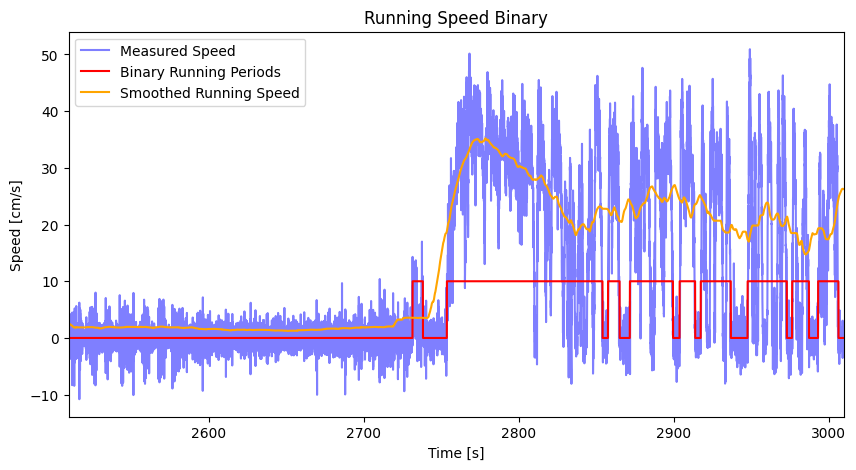

In [ ]:
# TODO über den teil müssen wir nochmal schauen!

# we filter the running speed signal
running_periods = utils.filter_running_speed(running_speed)
# convolution und smoothing mit root mean squared error
# Window size: we apply quite heavy smoothing for better visualization --> between 500-1000 is feasible here
running_smooth = utils.window_rms(running_speed, 750)

vis.filtered_running_speed(2500, 3000, running_periods, running_smooth)

In [ ]:
# correlation between running periods and spikes
# assert running_periods.shape[0] == inferred_spikes["binspikes"].shape[1]
# utils.analyze_spike_running_correlation(inferred_spikes["binspikes"], running_periods)

# TODO am ende schauen ob wir das noch wollen

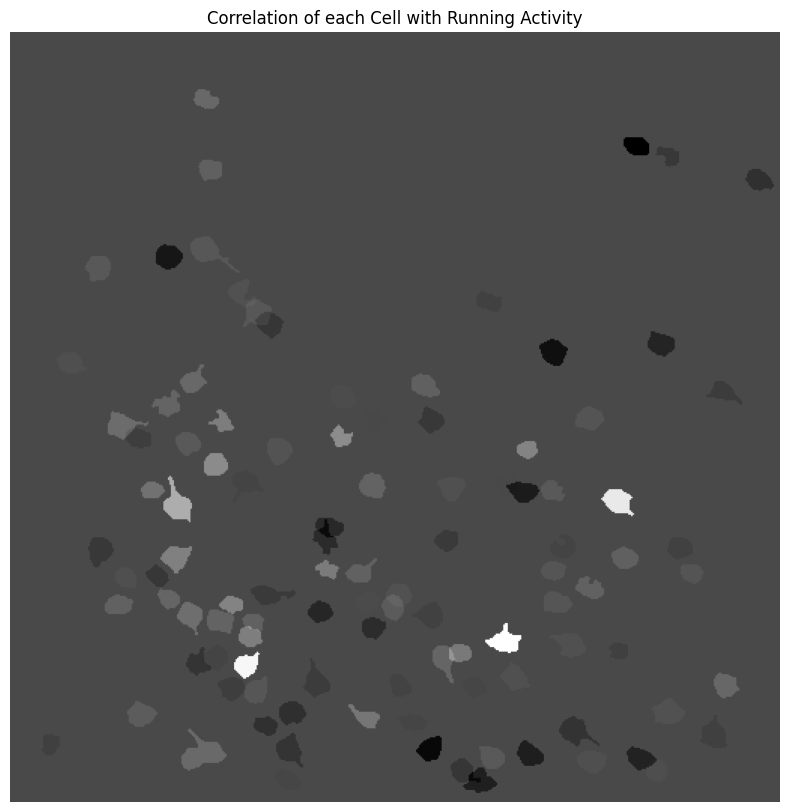

In [ ]:
from scipy.stats import ttest_ind, mannwhitneyu, pearsonr

roi_masks = data["roi_masks"].copy()
roi_masks_corr = np.zeros_like(roi_masks, dtype=np.float64)
for cell in range(roi_masks.shape[0]):
    corr, p = pearsonr(inferred_spikes["binspikes"][cell], running_speed)
    roi_masks_corr[cell, :, :] = np.where(
        roi_masks[cell, :, :].astype(np.float64) < 1, roi_masks[cell, :, :], corr
    )

roi_masks_sum = np.sum(roi_masks, axis=0)
roi_masks_sum = roi_masks_sum / np.max(roi_masks_sum)

roi_masks_corr_sum = np.sum(roi_masks_corr, axis=0)
roi_masks_corr_sum = roi_masks_corr_sum / np.max(roi_masks_corr_sum)


fig, axs = plt.subplots(1, 1, figsize=(10, 10))
# axs.imshow(roi_masks_sum, cmap="gray", alpha=0.5)
axs.imshow(
    roi_masks_corr_sum, cmap="gray"
)  # TODO diverging color bar mit limits einfügen... Stephan macht das noch

axs.set_title("Correlation of each Cell with Running Activity")
axs.axis("off")
plt.show()

# TODO Plot schöner machen: Top 10 korrelationen (absolutwerte nehmen) und codieren sowie liste evtl.

## Question

**Is there spatial structure in the preferred orientation/direction/temporal frequency?**

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing 
2. Spike inference 
3. Tuning function fitting 
4. Statistical testing. 

It is sufficient to assess spatial structure visually. Bonus points for proper statistical assessment. Also bonus points if you focus on specific cell types.

In [ ]:
fitted_tuning_curves = utils.fitTemporalTuningCurve(
    inferred_spikes,
    stim_table,
)
# DAVID
# The dictionary contains the fitted tuning curves, mean spike counts and standard deviations for each neuron
# access like this: fitted_tuning_curves[neuron]["fitted_curves"], fitted_tuning_curves[neuron]["mean_spike_counts"], fitted_tuning_curves[neuron]["std_spike_counts"]
# fitted_tuning_curves[0]["fitted_curves"].shape # (n_temporal_frequencies, n_directions)

100%|██████████| 106/106 [00:21<00:00,  4.85it/s]


In [ ]:
max_of_temporal_tuning_curve = utils.getMaxOfTemporalTuningCurves(
    fitted_tuning_curves.copy(), stim_table
)
max_of_temporal_tuning_curve[0]

{'max_direction': 90.0, 'max_direction2': 270.0, 'is_orientationnal': 1}

In [ ]:
interact(
    vis.update_temporal_tuning_curve,
    cellIdx=vis.cell_index_slider(),
    tuning_curve_fit=fixed(fitted_tuning_curves),
)

# TODO DAVID: Diese Function ist weird, fix das max problem!

interactive(children=(IntSlider(value=0, continuous_update=False, description='Cell Index:', layout=Layout(wid…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [ ]:
# TODO STEPH YOU KNOW -> ORIENTATION AND FREQUENCY NEXT TO EACH OTHER
def plotTestTuningFunction(
    neuron: int,
    qp_results: dict,
    qdistr: np.ndarray,
    stim_table,
) -> None:
    freq_strings = [1.0, 2.0, 4.0, 8.0, 15.0]
    freq_strings.append(-1)
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    for i, ax in enumerate(axs.flatten()):
        tf = freq_strings[i]
        q = qp_results[tf]["q"]

        ax.hist(
            qdistr[cellIdx, i, :],
            bins=30,
            color="skyblue",
            edgecolor="black",
            alpha=0.7
        )
        ax.axvline(q, color="red", linestyle="--", label=f"Observed |q| = {q:.2f}")
        if tf == -1:
            ax.set_title("All Temporal Frequencies")
        else:
            ax.set_title(f"Temporal Frequency: {tf} Hz")
    for ax in axs.flatten():
        ax.set_xlabel("|q| Values")
        ax.set_ylabel("Frequency")
        ax.set_xlim(left=0)
        ax.legend()
    plt.suptitle(f"Permutation Test Direction Tuning of Neuron {neuron}")
    plt.tight_layout()
    plt.show()

In [ ]:
# as this functions take a while to compute, we provide the results as a file
from_file = True
if not from_file:
    testTuningFunctionResultsOr, qdistr_Or = utils.testTuningFunction_opt(
        inferred_spikes, stim_table, psi=2
    )
    testTuningFunctionResultsDir, qdistr_Dir = utils.testTuningFunction_opt(
        inferred_spikes, stim_table, psi=1
    )
else:
    testTuningFunctionResultsOr, qdistr_Or = utils.load_tuning_test_results(
        orientation=True
    )
    testTuningFunctionResultsDir, qdistr_Dir = utils.load_tuning_test_results(
        orientation=False
    )
# DAVID
# Return a dictionary with the p-values, q-values and qdistr for each neuron and temporal frequency
# Access like this: testTuningFunctionResults[neuron][temporal_frequency]["p"], testTuningFunctionResults[neuron][temporal_frequency]["q"], testTuningFunctionResults[neuron][temporal_frequency]["qdistr"]
# temporal_frequency = -1 means all directions
testTuningFunctionResultsOr[0].keys()

dict_keys([1, 2, 4, 8, 15, -1])

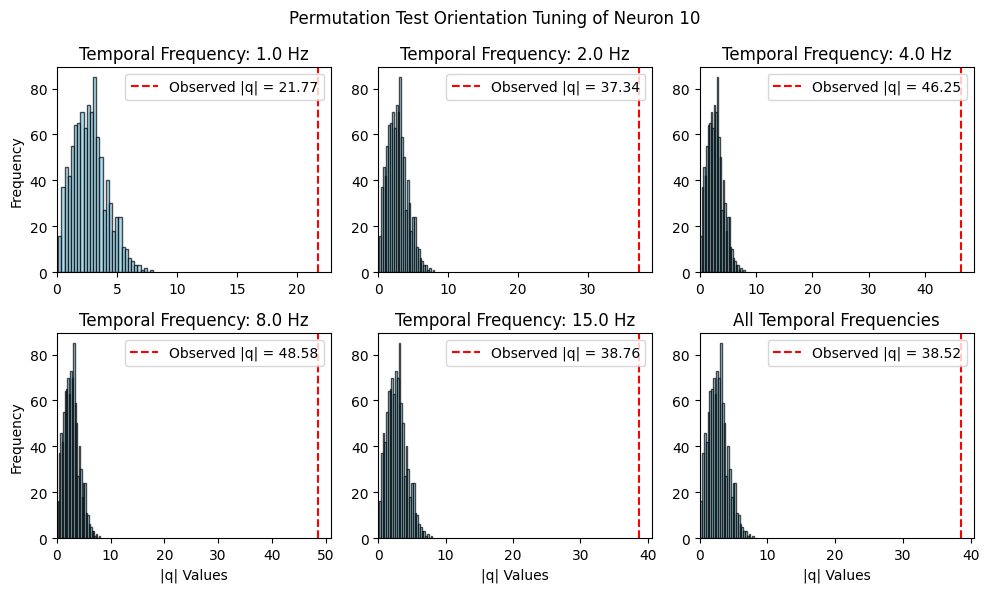

In [ ]:
vis.plot_tuning_orientation_test(10, testTuningFunctionResultsOr, qdistr_Or)

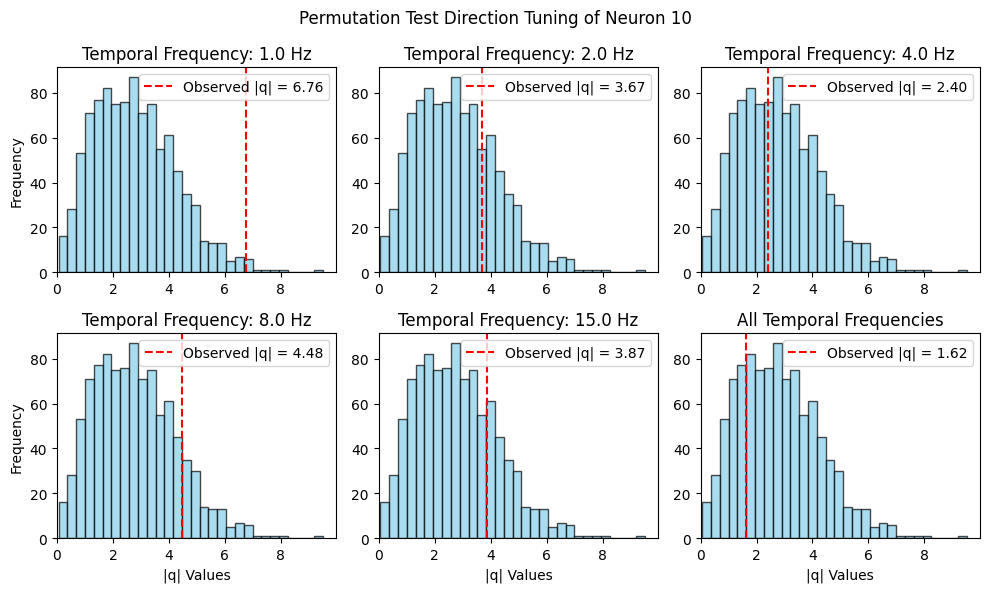

In [ ]:
vis.plot_tuning_orientation_test(
    10, testTuningFunctionResultsDir, qdistr_Dir, direction=True
)

Todo:

- peri stimulius time plots aus CL4 -> Histogram (Stephan weiß)
- spatial structure: preferred orientation (max der tuning curve) einfärben (wenn signifikant?) = Direction?

- überlegen wie spatial frequency da rein kommt und warum temporal frequency gegeben wurde 
- Complex / simple cells 

In [ ]:
# TODO stephan modelt die nächsten zwei zellen um

unique_dirs = np.unique(stim_table["temporal_frequency"].dropna())
neurons = inferred_spikes["binspikes"].shape[0]
temporal_tunings = np.zeros((2, neurons, len(unique_dirs)))
for neuron in range(neurons):
    spike_count = utils.bin_spike_counts(stim_table, inferred_spikes, neuron=neuron)
    spike_count = spike_count[stim_table["temporal_frequency"].dropna().index]
    temporal_tuning_mean = np.array(
        [
            np.mean(spike_count[stim_table["temporal_frequency"].dropna() == d])
            for d in unique_dirs
        ]
    )
    temporal_tuning_sd = np.array(
        [
            np.std(spike_count[stim_table["temporal_frequency"].dropna() == d])
            for d in unique_dirs
        ]
    )
    temporal_tunings[0, neuron, :] = temporal_tuning_mean
    temporal_tunings[1, neuron, :] = temporal_tuning_sd

<matplotlib.legend.Legend>

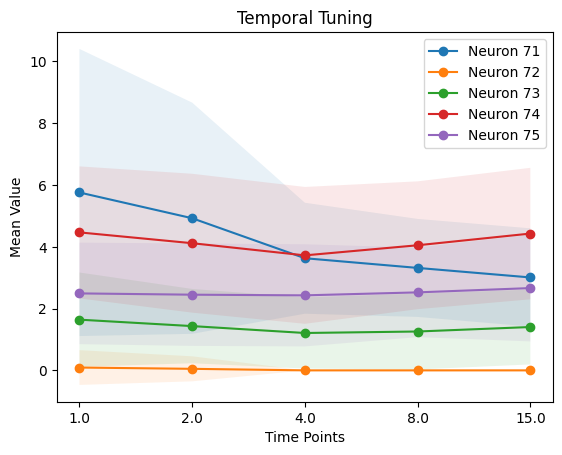

In [ ]:
# TODO: Den plot hier interakitv machen? Für alle Neurone?
x = np.arange(temporal_tunings.shape[2])

for neuron_index in range(70, 75):
    temporal_tuning_mean = temporal_tunings[0, neuron_index, :]
    temporal_tuning_sd = temporal_tunings[1, neuron_index, :]
    # Plot mean line
    plt.plot(x, temporal_tuning_mean, marker="o", label=f"Neuron {neuron_index + 1}")
    plt.errorbar(
        x,
        temporal_tuning_mean,
        yerr=temporal_tuning_sd,
        fmt="o",
        capsize=5,
        label=f"Neuron {neuron_index + 1}",
    )
    # # Plot shaded area for SD
    # plt.fill_between(
    #     x,
    #     temporal_tuning_mean - temporal_tuning_sd,
    #     temporal_tuning_mean + temporal_tuning_sd,
    #     alpha=0.1,
    # )  # Adjust alpha for transparency

# Add titles and labels
plt.title("Temporal Tuning")
plt.xlabel("Time Points")
plt.ylabel("Mean Value")

# Set the custom x-tick labels
plt.xticks(ticks=x, labels=unique_dirs)

# Add a legend
plt.legend()

# TODO Stephan sagt, der plot macht keinen sinn.

## Complex vs Simple Cells:

Dividing Simples Cells and Complex Cells by the f1/f0 ratio is a well known procedure, first noted by Hubel and Wiesel (1962; Journal of Physiology, London, 160, 106–154). Because it has been verifyed many times we use the same ratio to classify simple and complex cells. 


Paper sagt: https://doi.org/10.1016/j.visres.2012.09.004
F0 (or mean activity, in spikes/s) values reported here are the
firing rates averaged over the time of stimulus presentation in sin-
gle trial or, depending on the test, averaged over all trials with gi-
ven stimulus parameters. The F1 values reported here are the
magnitudes of the first component (at stimulus temporal fre-
quency) of the frequency spectra. In the case of recordings from
subcortical structures, where visual stimulation lasted for 1 s only
data obtained during stimulation with gratings drifting at temporal
frequencies above 1 Hz were taken into account.

In [ ]:
from scipy.fft import fft

stimulus_frequency = 0.5  # 1 stimulus every 2s
neurons = inferred_spikes["binspikes"].shape[0]
spike_count = np.zeros((neurons, stim_table["orientation"].shape[0]))
p_direction = np.zeros(neurons)
f1_comp = np.zeros(neurons)
for neuron in range(neurons):
    counts = utils.bin_spike_counts(stim_table, inferred_spikes, neuron=neuron)
    spike_count[neuron, :] = counts
    # Compute FFT of the spike counts
    fft_result = fft(counts)
    freqs = np.fft.fftfreq(len(counts), d=(1.0 / stimulus_frequency))
    # Magnitude of DC component
    f0 = np.mean(counts)
    # Find the index of the frequency closest to the stimulus frequency
    f1_index = np.argmin(
        np.abs(
            freqs - stimulus_frequency
        )  # find index of the frequency that is closest to stimulus frequency
    )  # fundamental frequency, f1 is the LOWEST POSSIBLE frequency of vibration in the system.
    #  The F1 values reported here are the magnitudes of the first component (at stimulus temporal frequency) of the frequency spectra
    # Compute the magnitude (amplitude) of the first harmonic component (F1)
    f1 = 2.0 / len(counts) * np.abs(fft_result[f1_index])
    f1_comp[neuron] = f1 / f0

C:\Users\Hannah Blaurock\AppData\Local\Temp\ipykernel_15964\4081585994.py:25: RuntimeWarning: invalid value encountered in double_scalars
  f1_comp[neuron] = f1 / f0


In [ ]:
# Initialize an empty list to collect rows
rows = []

p_tresh = 0.01

# Iterate through each neuron and its p-values
for neuron, temporal_resolutions in testTuningFunctionResults.items():
    # Create a row with the neuron index and its p-values
    row = {"Neuron": neuron}
    for resolution, values in temporal_resolutions.items():
        row["first_harmonic"] = values[
            "q"
        ]  # Extract the q value (only with dir bc we look at first harmonic there)
        row[resolution] = 1 if values["p"] <= p_tresh else 0  # Extract the p value
    rows.append(row)

# Create DataFrame from rows
df = pd.DataFrame(rows)

# Set the Neuron column as the index
df.set_index("Neuron", inplace=True)

In [ ]:
df["f1_f0"] = df["first_harmonic"] / np.mean(spike_count, axis=1)
df["complex"] = [1 if df["f1_f0"][neuron] > 1 else 0 for neuron in range(len(df))]
# Convert the dictionary to a DataFrame
max_df = pd.DataFrame.from_dict(max_of_temporal_tuning_curve, orient="index")

# Concatenate the new DataFrame with the existing one
df = pd.concat([df, max_df], axis=1)

In [ ]:
df

,first_harmonic,1,2,4,8,15,-1,f1_f0,complex,max_direction,max_direction2,is_orientationnal
0,0.449902,1,1,0,1,0,0,0.105899,0,90.0,0.0,0
1,1.191632,0,0,0,1,1,0,0.612895,0,45.0,0.0,0
2,0.748671,1,1,0,1,0,0,0.221881,0,0.0,0.0,0
3,0.700572,1,1,0,1,1,0,0.512773,0,45.0,0.0,0
4,0.446955,0,1,0,1,1,0,0.632180,0,135.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
101,0.463943,0,1,1,0,1,0,0.392663,0,45.0,0.0,0
102,2.282478,1,1,0,1,1,1,0.595512,0,45.0,0.0,0
103,1.602087,1,1,1,1,0,0,0.406017,0,180.0,0.0,1
104,0.388397,0,1,1,1,0,0,0.160048,0,315.0,0.0,0


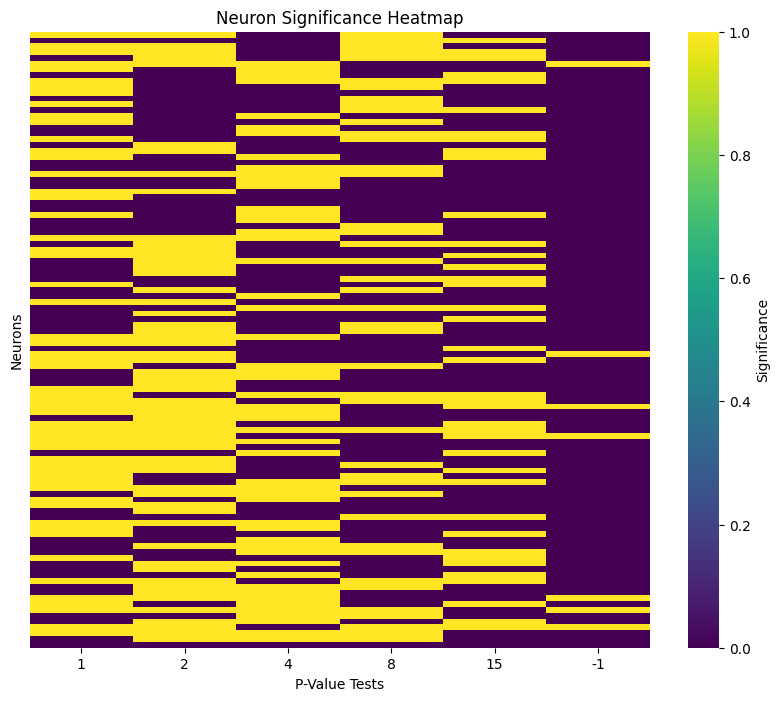

In [ ]:
import seaborn as sns

keys = ["1", "2", "4", "8", "15", "-1"]

plt.figure(figsize=(10, 8))
sns.heatmap(
    df.iloc[:, 1:7],
    cmap="viridis",
    cbar_kws={"label": "Significance"},
    yticklabels=False,
)
plt.xlabel("P-Value Tests")
plt.ylabel("Neurons")
plt.title("Neuron Significance Heatmap")
plt.show()